# <center> <b> Zomato Interactive Dashboard </b> </center>

#### Bengaluru Is India's IT Capital. The city with a huge number of tech firms is known as India's Silicon Valley. Many of the students and workers have shifted in Bengaluru due to their work and they are heavily reliant on the restaurant food. The goal of the project is to analyze the Zomato Bengaluru dataset in order to get a good understanding of the factors that affect the restaurants in Bengaluru. This can also can help new start-up restaurants determine their location, restaurant type, menus, cuisine, cost of the dishes etc.


<center> <img src="https://upload.wikimedia.org/wikipedia/commons/e/ef/Zomato-flat-logo.png" width=500 height=500 /> </center>

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.core.display import display, HTML
from google_drive_downloader import GoogleDriveDownloader as gdd
from os import path
import ipywidgets as widgets
import geopy
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
import wordcloud
from wordcloud import WordCloud

In [6]:
gdd.download_file_from_google_drive(file_id='1m7dYpCbDSsnejatx4Zd12ssggXYZgq8z',
                                    dest_path='./zomato.csv',
                                    unzip=False)
gdd.download_file_from_google_drive(file_id='1YfVAJFiNFUdZVKusOFWiw6mcvAsQhWZw',
                                    dest_path='./loc.csv',
                                    unzip=False)

In [10]:
df=pd.read_csv("zomato.csv")
df= df.drop(['Unnamed: 0','reviews_list','menu_item','listed_in(city)','url'],1)

# <center> <b> Get the details of the desired restaurant </b> </center>

In [11]:
pd.set_option('max_colwidth', None)

In [12]:
def rest(Restaurant_Name):
  res = df[(df.name == Restaurant_Name)]
  return res
interact(rest, Restaurant_Name='Jalsa');

interactive(children=(Text(value='Jalsa', description='Restaurant_Name'), Output()), _dom_classes=('widget-int…

# <center> <b> Type your Bangalore location and get highly rated budget-friendly restaurant options! </b> </center>

In [15]:
df['rate']=df['rate'].replace('NEW',np.nan)
df['rate']=df['rate'].replace('-',np.nan)
cost_dist=df[['rate','approx_cost(for two people)','location','name']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x : float(x.split('/')[0]))
cost_dist['approx_cost(for two people)']=cost_dist['approx_cost(for two people)'].apply(lambda x: int(x.replace(',','')))
def return_budget(location):
    budget=cost_dist[(cost_dist['approx_cost(for two people)']<=400) & (cost_dist['location']==location) & (cost_dist['rate']>4)]
    budget=budget['name'].unique()
    budget= pd.DataFrame(budget)
    return (budget)
interact(return_budget, location='BTM');

interactive(children=(Text(value='BTM', description='location'), Output()), _dom_classes=('widget-interact',))

# <center> <b> Which are the top restaurant chains in Bangalore? </b> </center>

In [28]:
def top(n):
  chain = df['name'].value_counts().head(n).to_frame()
  fig = px.bar(chain, x = chain.index, y = 'name', color='name')
  fig.show();
interact(top, n=10);

interactive(children=(IntSlider(value=10, description='n', max=30, min=-10), Output()), _dom_classes=('widget-…

# <center> <b> Heatmap of restaurants in Bangalore <b/> </center>

In [18]:
loc = pd.read_csv("loc.csv")

In [19]:
loc["Name"]=loc['Name'].apply(lambda x :  x.replace("Bangalore","")[1:])
Rest_locations=pd.DataFrame(df['location'].value_counts().reset_index())
Rest_locations.columns=['Name','count']
Rest_locations=Rest_locations.merge(loc,on='Name',how="left").dropna()
Rest_locations['lat'], Rest_locations['lon'] = Rest_locations['geo_loc'].str.split(',', 1).str
Rest_locations['lat'] = Rest_locations['lat'].apply(lambda x: x.replace('(','')) 
Rest_locations['lon'] = Rest_locations['lon'].apply(lambda x: x.replace(')','')) 
Rest_locations['lat']=Rest_locations['lat'].astype(float)
Rest_locations['lon']=Rest_locations['lon'].astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Columnar iteration over characters will be deprecated in future releases.



In [20]:
def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
basemap=generateBaseMap();
HeatMap(Rest_locations[['lat','lon','count']].values.tolist()).add_to(basemap);
basemap

# <center> <b> Rating Distribution </b> </center>

In [21]:
rating=df['rate'].dropna().apply(lambda x : float(x.split('/')[0]))
rating = rating.value_counts().to_frame()
fig = px.bar(rating, x = rating.index, y = rating.rate, color= rating.rate,labels={'rate':'count','x':'Rating'})
fig.show();

# <center> <b> Top Foodie Areas in Bangalore <b/> </center>

In [27]:
def top_area(n):
    foodie = df['location'].value_counts().head(n).to_frame()
    fig=px.bar(foodie, x = foodie.index, y = 'location', color='location')
    fig.show();
interact(top_area, n=5);

interactive(children=(IntSlider(value=5, description='n', max=15, min=-5), Output()), _dom_classes=('widget-in…

# <center> <b> Restaurant ratings v/s Cost for two (hover over each data point for more details) <b/> </center>

In [ ]:
df['rate']=df['rate'].dropna().apply(lambda x : float(x.split('/')[0]))

In [24]:
df = df.sort_values(by='rate',ascending = True)
trace = go.Scatter(y = df['rate'], x = df['approx_cost(for two people)'], text = df['name'], mode = 'markers')
layout = go.Layout(title='Cost v/s Ratings', xaxis = dict(title='Cost for two'), yaxis = dict(title='Restaurant Rating'))
go.Figure(data = trace , layout = layout)

# <center> <b> Top Dishes liked in Bangalore <b/> </center>

In [25]:
df['dish_liked']=df['dish_liked'].apply(lambda x : x.split(',') if type(x)==str else [''])

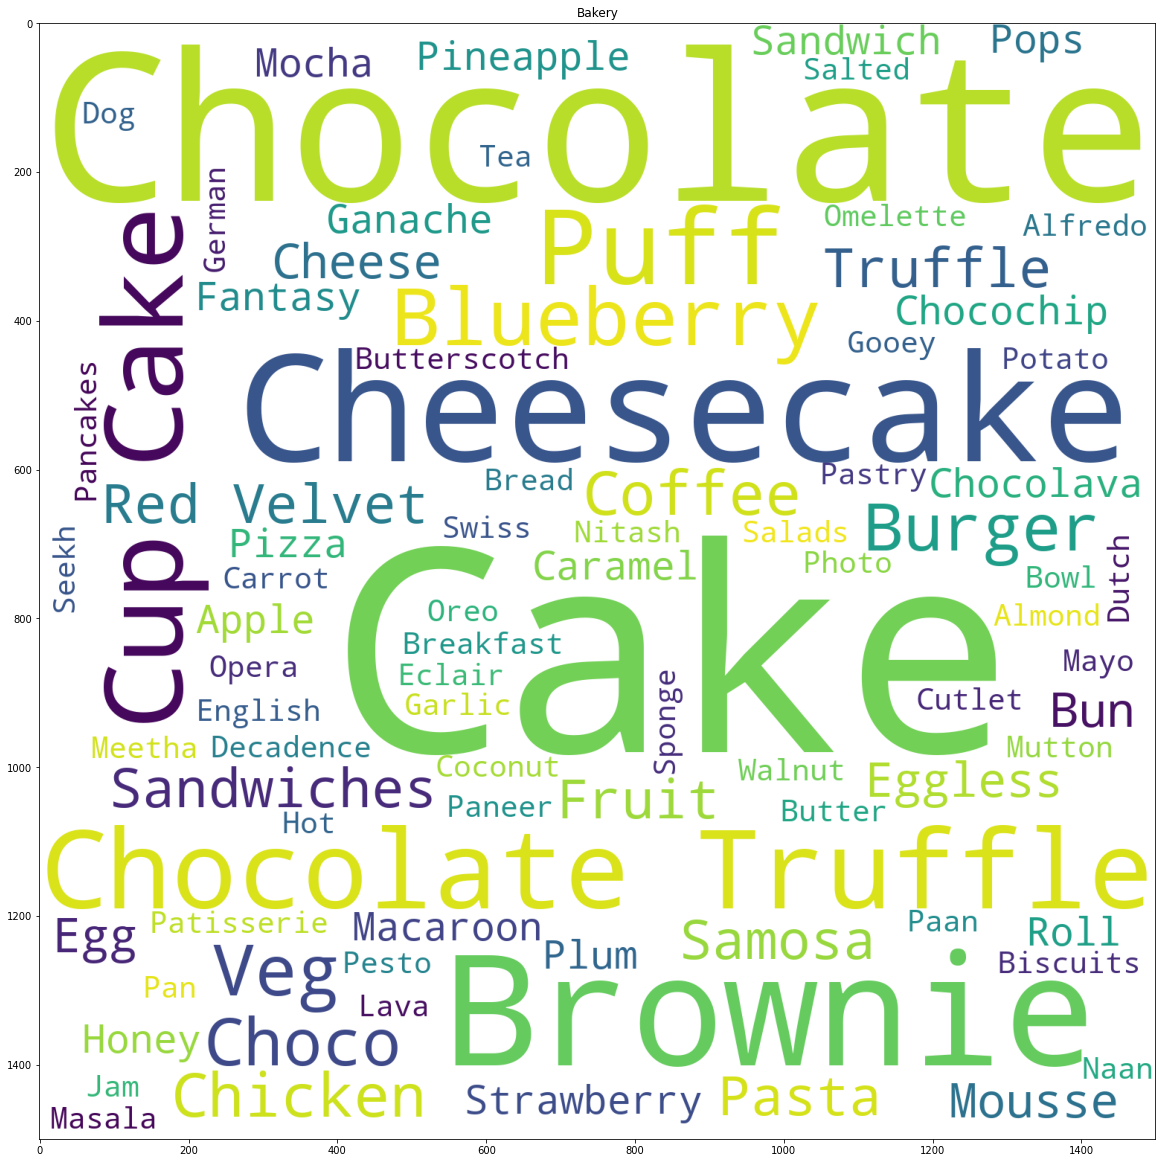

In [26]:
def produce_wordcloud(rest):
    plt.figure(figsize=(20,30))
    corpus=df[df['rest_type']==rest]['dish_liked'].values.tolist()
    corpus=','.join(x  for list_words in corpus for x in list_words)
    wordcloud = WordCloud(max_font_size=None, background_color='white', width=1500, height=1500, random_state=1).generate(corpus)
    plt.imshow(wordcloud)
    plt.title(rest)
    
interact(produce_wordcloud, rest='Bakery');